# 8-5. 프로젝트 : 개선된 U-Net 모델 만들기

In [ ]:
import os
import math
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [ ]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224
            )
        ])
    return Compose([
        Resize(
            width=224,
            height=224
        )
    ])

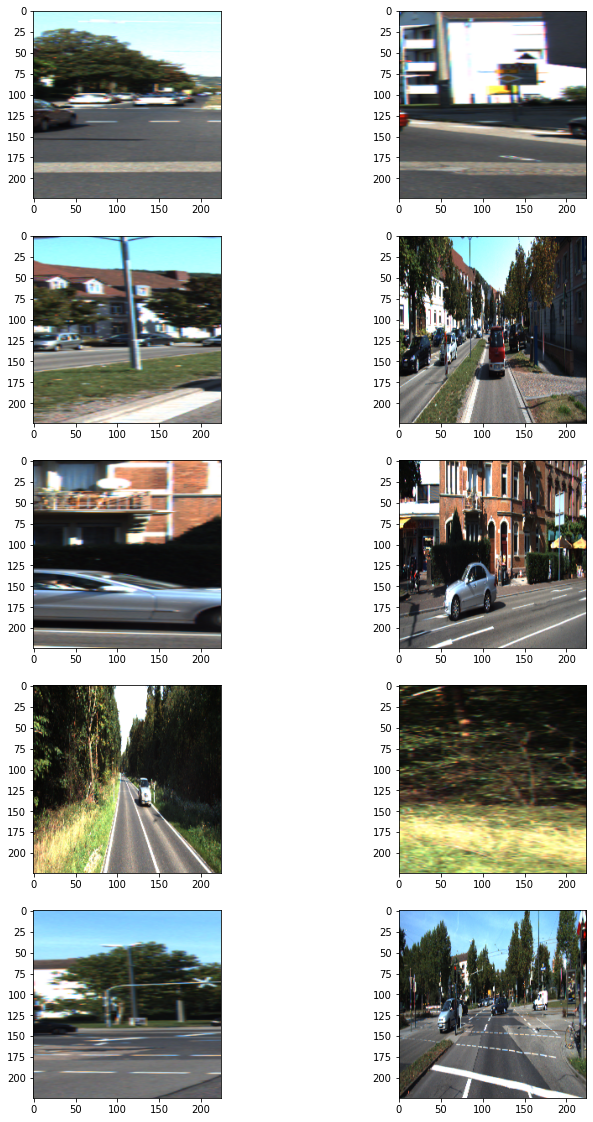

In [ ]:
dir_path = './data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## U-Net

In [ ]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

In [ ]:
def build_UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3,up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2,up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
UNet = build_UNet()
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 220, 220, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
UNet.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

In [ ]:
UNet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 15s 136ms/step - loss: 0.7467 - val_loss: 0.6953
Epoch 2/100
43/43 [==============================] - 6s 128ms/step - loss: 0.6276 - val_loss: 0.6715
Epoch 3/100
43/43 [==============================] - 6s 127ms/step - loss: 0.5664 - val_loss: 0.6347
Epoch 4/100
43/43 [==============================] - 6s 128ms/step - loss: 0.5164 - val_loss: 0.6344
Epoch 5/100
43/43 [==============================] - 6s 128ms/step - loss: 0.4698 - val_loss: 0.6885
Epoch 6/100
43/43 [==============================] - 6s 129ms/step - loss: 0.4207 - val_loss: 0.6537
Epoch 7/100
43/43 [==============================] - 6s 130ms/step - loss: 0.3852 - val_loss: 0.6805
Epoch 8/100
43/43 [==============================] - 6s 130ms/step - loss: 0.3479 - val_loss: 0.6719
Epoch 9/100
43/43 [==============================] - 6s 131ms/step - loss: 0.3144 - val_loss: 0.6725
Epoch 10/100
43/43 [==============================] - 6s 130ms/step - loss: 0.2920 - val_l

In [ ]:
UNet_model_path = './model/seg_model_unet.h5'
UNet.save(UNet_model_path)

## U-Net++

In [ ]:
def build_UNet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path(Backbone)
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1, conv2_1, conv3_1
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    # conv1_2, conv2_2
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    # conv1_3
    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [ ]:
UNet_plus = build_UNet_plus()
UNet_plus.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 222, 222, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 220, 220, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 220, 220, 64) 256         conv2d_24[0][0]                  
____________________________________________________________________________________________

In [ ]:
UNet_plus.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
UNet_plus.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 29s 428ms/step - loss: 0.1706 - val_loss: 0.5307
Epoch 2/100
43/43 [==============================] - 18s 426ms/step - loss: 0.1010 - val_loss: 0.6857
Epoch 3/100
43/43 [==============================] - 18s 422ms/step - loss: 0.0869 - val_loss: 0.4998
Epoch 4/100
43/43 [==============================] - 18s 416ms/step - loss: 0.0766 - val_loss: 0.6852
Epoch 5/100
43/43 [==============================] - 18s 415ms/step - loss: 0.0739 - val_loss: 0.3654
Epoch 6/100
43/43 [==============================] - 18s 418ms/step - loss: 0.0667 - val_loss: 0.5054
Epoch 7/100
43/43 [==============================] - 18s 420ms/step - loss: 0.0751 - val_loss: 0.3930
Epoch 8/100
43/43 [==============================] - 18s 419ms/step - loss: 0.0705 - val_loss: 0.3244
Epoch 9/100
43/43 [==============================] - 18s 417ms/step - loss: 0.0674 - val_loss: 0.3112
Epoch 10/100
43/43 [==============================] - 18s 416ms/step - loss: 0.064

In [ ]:
UNet_plus_model_path = './model/seg_model_unet_plus.h5'
UNet.save(UNet_plus_model_path)

## U-Net vs U-Net++

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    plt.figure(figsize=(12, 20))
    plt.imshow(output)

    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### U-Net

IoU : 0.861382


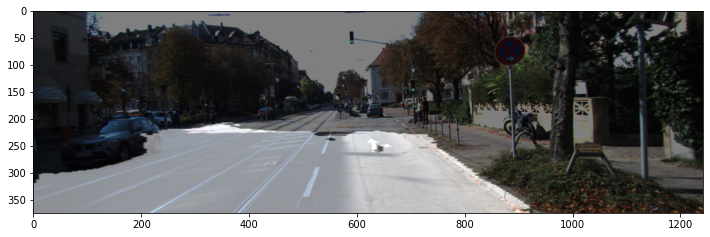

In [ ]:
i = 1
output, prediction, target = get_output(
     UNet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### U-Net++

IoU : 0.867161


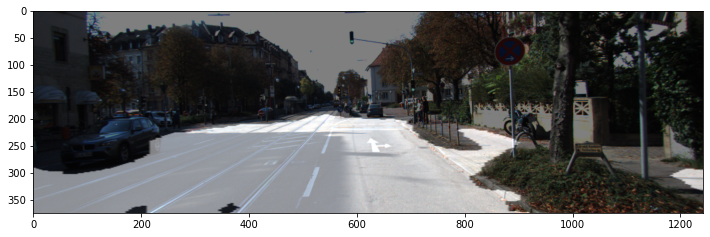

In [ ]:
i = 1
output, prediction, target = get_output(
     UNet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## Report

U-Net과 U-Net++를 구현하고 비교하였습니다.  

같은 이미지에 대해서 성능을 테스트 해본결과 U-Net++의 성능이 약간 더 좋은것을 나타났습니다.
- IoU
 - U-Net   : IoU : 0.861382
 - U-Net++ : IoU : 0.867161